## Libraries

In [2]:
from keras.layers import TextVectorization
import re
import string
import tensorflow as tf
import os
import pathlib
import shutil
import random
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers


## Config

In [61]:
DATASET_PATH ="C:/Users/Tajr/Desktop/UDSM/Experiments/datasets/"
OUTPUT_PATH = "C:/Users/Tajr/Desktop/UDSM/Experiments/textLab/outputs/"
MODEL_PATH = os.path.join(OUTPUT_PATH, 'model/')
IMDB_REVIEWS_PATH = os.path.join(DATASET_PATH, os.listdir(DATASET_PATH)[0])
IMDB_DENSE_OUTPUT = os.path.join(OUTPUT_PATH, 'imdb_dense/')
IMDB_LSTM_OUTPUT = os.path.join(OUTPUT_PATH, 'imdb_lstm/')
BATCH_SIZE = 32
MAX_TOKENS = 20000
MULTIPLE_CPU = 5
EPOCHS = 10

## Utils

In [4]:
def get_val_samples():
    base_dir = pathlib.Path(IMDB_REVIEWS_PATH)
    val_dir = base_dir / "val"
    train_dir = base_dir / "train"

    for category in ("neg", "pos"):
        os.makedirs(val_dir / category)
        files = os.listdir(train_dir / category)
        random.Random(1337).shuffle(files)
        num_val_samples = int(0.2 * len(files))
        val_files = files[-num_val_samples:]

        for fname in val_files:
            shutil.move(train_dir / category / fname, val_dir / category / fname)
            
# Accessing data
def inspect_dataset(dataset):
    for inputs, targets in dataset:
        print('inputs.shape: ', inputs.shape)
        print('inputs.dtype: ', inputs.dtype)
        print('targets.shape: ', targets.shape)
        print('targets.dtype: ', targets.dtype)
        print()
        print('Label: {}'.format(targets[0]))
        print('Sample: {}'.format(inputs[0]))
        break

# define and compile your model     
def get_model(max_tokens=MAX_TOKENS, hidden_dim=16):
    # define inputs, hidden layers, and output layer
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation='relu')(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    # define model
    model = keras.Model(inputs, outputs)
    
    # compile your model
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    # return your model
    return model

# check if output dir exist, if not create it
def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# Visualize training process
def plot_loss_accuracy(history, file_path):
    # set style
    mkdir(file_path)
    plt.style.use('ggplot')
    (fig, axs) = plt.subplots(2, 1)
    axs[0].plot(history['loss'], label='Training Loss')    
    axs[0].plot(history['val_loss'], label='Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()    
    axs[1].plot(history['accuracy'], label='Training Accuracy') 
    axs[1].plot(history['val_accuracy'], label='Validation Accuracy')    
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    fig.savefig(file_path)
    plt.show()

## Dataset

Sequential data - any data where the order or sequency is as essential as the data itself. example sentences, stock market data, audio data etc


### Raw data

In [5]:
# These dataset yield inputs that are Tensorflow tf.string tensors and 
# targets are int 32 tensors encoding the value 0 and 1
train_dataset = keras.utils.text_dataset_from_directory(os.path.join(IMDB_REVIEWS_PATH, 'train'), batch_size=BATCH_SIZE)
val_dataset = keras.utils.text_dataset_from_directory(os.path.join(IMDB_REVIEWS_PATH, 'val'), batch_size=BATCH_SIZE)
test_dataset = keras.utils.text_dataset_from_directory(os.path.join(IMDB_REVIEWS_PATH, 'test'), batch_size=BATCH_SIZE)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [6]:
# Accessing data
for i, line in enumerate(train_dataset.take(1)):
    print('Label: {}'.format(line[1][2]))
    print('Sample: {}'.format(line[0][2]))
  

Label: 0
Sample: b"Lets put it this way. I actually get this movie. I get what the writer/directer was trying to do. I understand that the dialog was meant to be dry and emotionless. I understand that the plot was supposed to be non-climactic and stale. That was what the writer/director was going for. A very very very dry humor/comedy. With all that understanding, I still think the movie sucked. It seemed like the writer/director was trying to recreate Napolean Dynamite with this movie. It had all of the same features. Even the main character behaved similar to Napolean. But Napolean Dynamite was actually funny. Its script worked. This movie is not. It has no purpose. Well, let me rephrase that. Its only purpose is to rip off Napolean Dynamite and try to capture that look and feel. Too bad it didn't work."


In [7]:
inspect_dataset(train_dataset)

inputs.shape:  (32,)
inputs.dtype:  <dtype: 'string'>
targets.shape:  (32,)
targets.dtype:  <dtype: 'int32'>

Label: 1
Sample: b'Elegance and class are not always the first words that come to mind when folks (at least folks who might do such a thing) sit around and talk about film noir. <br /><br />Yet some of the best films of the genre, "Out of the Past," "The Killers," "In A Lonely Place," "Night and the City," manage a level of sleek sophistication that elevates them beyond a moody catch phrase and its connotations of foreboding shadows, fedoras, and femme-fatales. <br /><br />"Where the Sidewalk Ends," a fairly difficult to find film -- the only copy in perhaps the best stocked video store in Manhattan was a rough bootleg from the AMC cable channel -- belongs in a category with these classics.<br /><br />From the moment the black cloud of opening credits pass, a curtain is drawing around rogue loner detective Marc Dixon\'s crumbling world, and as the moments pass, it inches ever c

## Data Processing

### Standardization, Tokenization and Vectorization

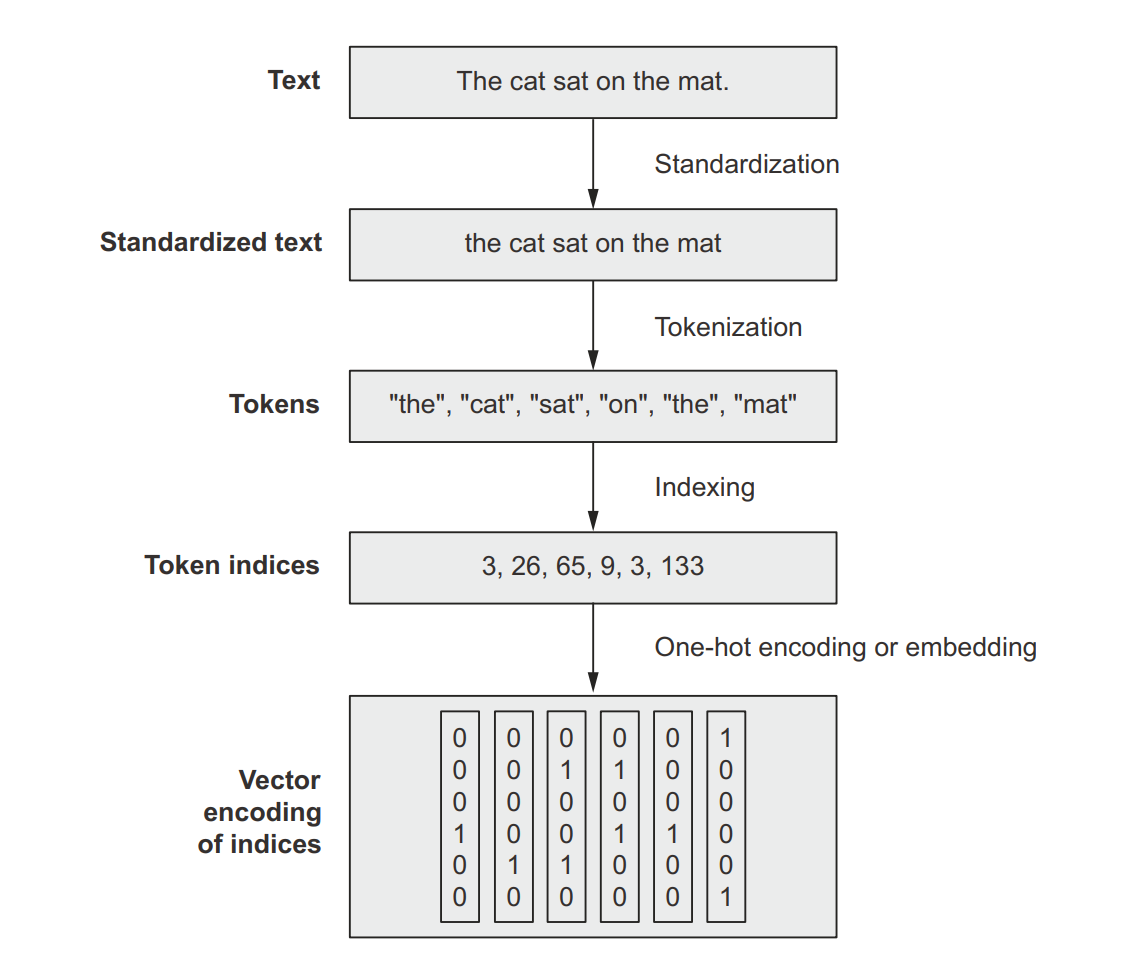

## BAG OF WORDS APPROACH (WORD AS A SET)
- Individual Words(Unigram)
- Group of consecutive tokens(N-grams)

##### Unigram with Binary Encoding

In practice you will use TextVectorization layer which is efficient and fast way of doing things.
- By defauld the layer will use the setting to convert to lowercase and remove punctuation (Standardizaztion), Split on whitespace (tokenization)
- It can receive custom function for standardization and tokenization
- Call adapt method to index the vocabulary of a text corpus

In [8]:
# define vectorizer
vectorizer = TextVectorization(max_tokens=MAX_TOKENS, output_mode='multi_hot')

In [9]:
# prepare a dataset that only yields raw text inputs no labels
text_only_train_ds = train_dataset.map(lambda x, y: x)

# use the dataset to index the dataset vocabulary via the adapt() method
vectorizer.adapt(text_only_train_ds)

In [10]:
# prepare the processed versions of our training validation and test dataset
train_ds = train_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)
val_ds = val_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)
test_ds = test_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)

In [11]:
inspect_dataset(train_ds)

inputs.shape:  (32, 20000)
inputs.dtype:  <dtype: 'float32'>
targets.shape:  (32,)
targets.dtype:  <dtype: 'int32'>

Label: 0
Sample: [1. 1. 1. ... 0. 0. 0.]


In [12]:
inspect_dataset(val_ds)

inputs.shape:  (32, 20000)
inputs.dtype:  <dtype: 'float32'>
targets.shape:  (32,)
targets.dtype:  <dtype: 'int32'>

Label: 0
Sample: [0. 1. 1. ... 0. 0. 0.]


In [13]:
inspect_dataset(test_ds)

inputs.shape:  (32, 20000)
inputs.dtype:  <dtype: 'float32'>
targets.shape:  (32,)
targets.dtype:  <dtype: 'int32'>

Label: 0
Sample: [1. 1. 1. ... 0. 0. 0.]


##### Bigrams

###### standardization, tokenization and vectorization

In [14]:
# prepare a dataset that only yield raw text inputs no labels
text_only_train_dataset = train_dataset.map(lambda x, y: x)

# use the dataset to index the dataset vocabulary via the adapt() method
vectorizer = TextVectorization(ngrams=2, max_tokens=MAX_TOKENS, output_mode='multi_hot')
vectorizer.adapt(text_only_train_dataset)

In [15]:
# create datasets
btrain_ds = train_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)
bval_ds = val_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)
btest_ds = test_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)

In [16]:
# inspect dataset
inspect_dataset(btrain_ds)

inputs.shape:  (32, 20000)
inputs.dtype:  <dtype: 'float32'>
targets.shape:  (32,)
targets.dtype:  <dtype: 'int32'>

Label: 1
Sample: [1. 1. 1. ... 0. 0. 0.]


##### Term Frequency, Inverse Document Frequency (TF-IDF)
- it weights a given term by taking term frequency, how many times the term appear in the current document and divide it by a measure of document frequency, which estimates how often the term comes up across the dataset

###### standardization, tokenization and vectorization

In [17]:
# get input text without labels
text_only_train_dataset = train_dataset.map(lambda x, y: x)

# vectorize with tf-idf
vectorizer = TextVectorization(ngrams=2, max_tokens=MAX_TOKENS, output_mode='tf_idf')
vectorizer.adapt(text_only_train_dataset)

In [18]:
# create datasets
tf_train = train_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)
tf_val = val_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)
tf_test = train_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)

In [19]:
# inspect dataset
inspect_dataset(tf_train)

inputs.shape:  (32, 20000)
inputs.dtype:  <dtype: 'float32'>
targets.shape:  (32,)
targets.dtype:  <dtype: 'int32'>

Label: 0
Sample: [490.86435     2.7906098   7.8228936 ...   0.          0.
   0.       ]


## MODEL

In [20]:
# define and compile your model
model = get_model()

# get model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense (Dense)               (None, 16)                320016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________


### Model Training (Unigram)

In [21]:
# define callbacks if any
callbacks = [
    keras.callbacks.ModelCheckpoint('binary_1gram.keras', save_best_only=True)
]

In [22]:
# fit or train your model with given datasets
history_dense = model.fit(train_ds.cache(), validation_data=val_ds.cache(), epochs=EPOCHS, callbacks=callbacks)

Epoch 1/10
625/625 [==============================] - 6s 9ms/step - loss: 0.4017 - accuracy: 0.8329 - val_loss: 0.2965 - val_accuracy: 0.8844
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2694 - accuracy: 0.9022 - val_loss: 0.2972 - val_accuracy: 0.8886
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2449 - accuracy: 0.9156 - val_loss: 0.3162 - val_accuracy: 0.8894
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2295 - accuracy: 0.9222 - val_loss: 0.3340 - val_accuracy: 0.8908
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2250 - accuracy: 0.9236 - val_loss: 0.3545 - val_accuracy: 0.8862
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2151 - accuracy: 0.9312 - val_loss: 0.3658 - val_accuracy: 0.8888
Epoch 7/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2157 - accuracy: 0.9306 - val_loss: 0.3828 - val_accuracy: 0.8816
Epoch 

#### Evaluation

In [23]:
model = keras.models.load_model('binary_1gram.keras')

In [24]:
print(f"Test acc: {model.evaluate(test_ds)[1]:.3f}")

782/782 [==============================] - 4s 5ms/step - loss: 0.2913 - accuracy: 0.8876
Test acc: 0.888


In [25]:
df = pd.DataFrame(data=history_dense.history)
df.describe()

,loss,accuracy,val_loss,val_accuracy
count,10.000000,10.000000,10.000000,10.000000
mean,0.243309,0.916355,0.353809,0.886480
std,0.058782,0.031139,0.040793,0.003273
min,0.208254,0.832900,0.296488,0.881400
25%,0.214578,0.917238,0.320637,0.884600
50%,0.220355,0.927075,0.360163,0.887300
75%,0.241080,0.933987,0.389981,0.888750
max,0.401717,0.935400,0.404760,0.890800


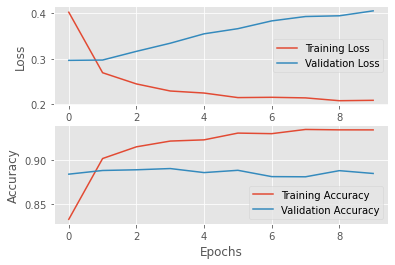

In [26]:
plot_loss_accuracy(history_dense.history,IMDB_DENSE_OUTPUT)

### Model Training (Bigram)

In [27]:
bigram_model = get_model()
bigram_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_2 (Dense)             (None, 16)                320016    
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________


In [28]:
callbacks = [keras.callbacks.ModelCheckpoint('bigram_model.keras', save_best_only=True)]

In [29]:
history_bigram_dense = bigram_model.fit(btrain_ds.cache(), validation_data=bval_ds, callbacks=callbacks, epochs=EPOCHS)

Epoch 1/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3635 - accuracy: 0.8528 - val_loss: 0.2851 - val_accuracy: 0.8894
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2338 - accuracy: 0.9169 - val_loss: 0.2896 - val_accuracy: 0.8920
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2060 - accuracy: 0.9344 - val_loss: 0.3084 - val_accuracy: 0.8930
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1934 - accuracy: 0.9424 - val_loss: 0.3262 - val_accuracy: 0.8950
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1797 - accuracy: 0.9470 - val_loss: 0.3429 - val_accuracy: 0.8956
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1698 - accuracy: 0.9502 - val_loss: 0.3717 - val_accuracy: 0.8926
Epoch 7/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1771 - accuracy: 0.9509 - val_loss: 0.3683 - val_accuracy: 0.8932
Epoch 

#### Evaluation

#### Testing

In [30]:
model = keras.models.load_model('bigram_model.keras')
print(f"Test acc: {model.evaluate(btest_ds)[1]:.3f}")

782/782 [==============================] - 4s 5ms/step - loss: 0.2737 - accuracy: 0.8943
Test acc: 0.894


#### Visualization

In [31]:
df = pd.DataFrame(data=history_bigram_dense.history)
df.describe()

,loss,accuracy,val_loss,val_accuracy
count,10.000000,10.000000,10.000000,10.000000
mean,0.204261,0.935490,0.343816,0.892840
std,0.059466,0.031235,0.039269,0.001859
min,0.168339,0.852800,0.285074,0.889400
25%,0.174894,0.936450,0.312868,0.892150
50%,0.178414,0.948600,0.355596,0.893100
75%,0.202809,0.951787,0.371604,0.893650
max,0.363513,0.954400,0.387831,0.895600


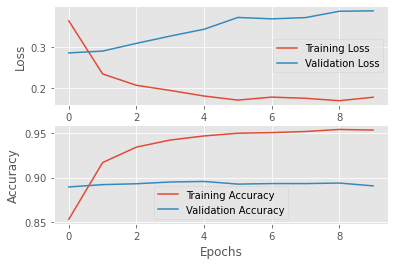

In [32]:
plot_loss_accuracy(history_bigram_dense.history,IMDB_DENSE_OUTPUT)

with bigram, hence local order is pretty important

### Model Training (TF-IDF)

In [33]:
# get model
tf_model = get_model()
tf_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_4 (Dense)             (None, 16)                320016    
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________


In [34]:
# callbacks
callbacks = [keras.callbacks.ModelCheckpoint('tf_model.keras', save_best_only=True)]

# train
tf_history = model.fit(tf_train.cache(), validation_data=tf_val.cache(), epochs=EPOCHS, callbacks=callbacks)

Epoch 1/10
625/625 [==============================] - 6s 9ms/step - loss: 0.4767 - accuracy: 0.9011 - val_loss: 0.2981 - val_accuracy: 0.8914
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2540 - accuracy: 0.9106 - val_loss: 0.3398 - val_accuracy: 0.8742
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2329 - accuracy: 0.9183 - val_loss: 0.3965 - val_accuracy: 0.8678
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2315 - accuracy: 0.9118 - val_loss: 0.3510 - val_accuracy: 0.8834
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2119 - accuracy: 0.9181 - val_loss: 0.3482 - val_accuracy: 0.8886
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2075 - accuracy: 0.9189 - val_loss: 0.3840 - val_accuracy: 0.8798
Epoch 7/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2066 - accuracy: 0.9186 - val_loss: 0.3661 - val_accuracy: 0.8882
Epoch 

### Evaluation

In [35]:
model = keras.models.load_model('tf_model.keras')
print(f'Test accuracy: {model.evaluate(tf_test)[1]:.3f}')

625/625 [==============================] - 3s 5ms/step - loss: 0.1587 - accuracy: 0.9457
Test accuracy: 0.946


In [36]:
df = pd.DataFrame(data=tf_history.history)
df.describe()

,loss,accuracy,val_loss,val_accuracy
count,10.000000,10.000000,10.000000,10.000000
mean,0.241518,0.915745,0.360620,0.880440
std,0.084789,0.006236,0.028943,0.007888
min,0.189239,0.901100,0.298129,0.867800
25%,0.206650,0.913338,0.348927,0.875600
50%,0.209677,0.918475,0.364618,0.880400
75%,0.232510,0.918800,0.379496,0.887000
max,0.476673,0.922300,0.396544,0.891400


### Visualization

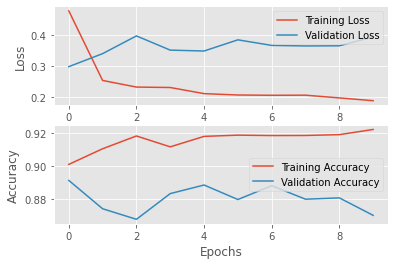

In [37]:
plot_loss_accuracy(tf_history.history,IMDB_DENSE_OUTPUT)

## Exporting a Model that process raw strings

## Inferencing

## THE SEQUENCE MODEL APPROACH  (WORDS AS A SEQUENCE)


### Config

In [47]:
# In order to keep a managable input size, we will truncate the inputs after the first 600 words
# this is a reasonable choice, since the average review length is 233 words, and only 5% of 
# reviews are longer than 600 words
MAX_LENGTH = 600

### Sequence data processiong

In [52]:
# Standardization, tokenization and vectorization
vectorizer = TextVectorization(max_tokens=MAX_TOKENS, output_mode='int', output_sequence_length=MAX_LENGTH)
vectorizer.adapt(text_only_train_dataset)

train_ds = train_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)
val_ds = val_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)
test_ds = test_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)

In [55]:
inspect_dataset(train_ds)

inputs.shape:  (32, 600)
inputs.dtype:  <dtype: 'int64'>
targets.shape:  (32,)
targets.dtype:  <dtype: 'int32'>

Label: 0
Sample: [  446   134   122    11    18   121  4186    44    23    68   121  1522
     5   312     4  6597     5     2  1143   534   227    15   703    15
   633     3    15 19680    31     2   167    61     1   776    56   989
     4   353  1337     5  1143    97   636     7     9   168  4885     7
 13824   199     4  3016     5     1     3     2   113   446     2   113
     1     2   685   197    10   139    26   618   124    15     2  1619
  3886  4110     5     2   425    58    26     1    70   125     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0 

### MODEL

In [58]:
def get_lstm(max_tokens=MAX_TOKENS, hidden_dim=32):
    # define
    inputs = keras.Input(shape=(None,), dtype='int64')
    embedded = tf.one_hot(inputs, depth=max_tokens) # encode the intergers into binary 20000 dimension vector
    x = layers.Bidirectional(layers.LSTM(hidden_dim))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    
    # compile
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    # return
    return model

In [59]:
model = get_lstm()
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot_1 (TFOpLambda)   (None, None, 20000)       0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               5128448   
 l)                                                              
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,128,513
Trainable params: 5,128,513
Non-trainable params: 0
_________________________________________________

### Train

In [62]:
callbacks = [keras.callbacks.ModelCheckpoint('one_hot_bidir_lstm.keras', save_best_only=True)]
history_lstm = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/10
 73/625 [==>...........................] - ETA: 41:03 - loss: 0.6925 - accuracy: 0.5347

KeyboardInterrupt: 

### Evaluation

In [ ]:
# read train history
df = pd.DataFrame(history_lstm.history)
df.describe()

In [ ]:
# load your model
model = keras.models.load_model('one_hot_bidir_lstm.keras')
model.summary()

In [ ]:
# run a test
print(f'{model.evaluate(test_ds)[1]:.3f}')

### Visualization

In [ ]:
plot_loss_accuracy(history_lstm.history, IMDB_LSTM_OUTPUT)